In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
real_estate: pd.DataFrame = pd.read_excel('data/Real estate valuation data set.xlsx')
real_estate.drop(['No'], axis=1, inplace=True)

short = real_estate.copy()
short.columns = short.columns.map(lambda x: x.split(' ')[0])
display(short.head())

,X1,X2,X3,X4,X5,X6,Y
0,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [4]:
X_matrix: np.ndarray = np.array(real_estate.drop(['Y house price of unit area'], axis=1))
y_matrix: np.ndarray = np.array(real_estate['Y house price of unit area']).reshape(-1, 1)

X_train: np.ndarray = X_matrix[0:315]
y_train: np.ndarray = y_matrix[0:315]

X_test: np.ndarray = X_matrix[315:]
y_test: np.ndarray = y_matrix[315:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((315, 6), (315, 1), (99, 6), (99, 1))

In [113]:
class NeuralNet:
    def __init__(self, X_train, y_train):

        self.W1 = np.random.random((5, 6))
        self.b1 = np.random.random((5, 1))
        self.W2 = np.random.random((1, 5))
        self.b2 = np.random.random((1, 1))

        self.loss_acum = []

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        self.z1 = self.W1 @ x.T + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = self.W2 @ self.a1 + self.b2
        self.a2 = self.z2
        return self.a2.reshape(-1, 1)
    
    def numerical_gradient(self, x, y, eps):
        """
        Una estrategia para calcular estas derivadas parciales, consiste en calcular el promedio
        de los cocientes incrementales a derecha e izquierda. Para obtener la siguiente aproximación, para
        cada parámetro de la red calculamos:

        $$
        \frac{\partial L}{\partial p} \sim \frac{L(\theta_t, p + \epsilon) - L(\theta_t, p - \epsilon)}{2 \epsilon}
        $$

        donde usamos $p$ de forma genérica para referirnos a cada elemento $w^1_{i,j}$, $b^1_{j}$, $w^2_{i,j}$, $b^2_{j}$
        """

        dW1 = np.zeros_like(self.W1)
        db1 = np.zeros_like(self.b1)
        dW2 = np.zeros_like(self.W2)
        db2 = np.zeros_like(self.b2)

        for i in range(self.W1.shape[0]):
            for j in range(self.W1.shape[1]):
                self.W1[i, j] += eps
                loss1 = self.loss(x, y)
                self.W1[i, j] -= 2 * eps
                loss2 = self.loss(x, y)
                dW1[i, j] = (loss1 - loss2) / (2 * eps)
                self.W1[i, j] += eps
        
        for i in range(self.b1.shape[0]):
            for j in range(self.b1.shape[1]):
                self.b1[i, j] += eps
                loss1 = self.loss(x, y)
                self.b1[i, j] -= 2 * eps
                loss2 = self.loss(x, y)
                db1[i, j] = (loss1 - loss2) / (2 * eps)
                self.b1[i, j] += eps

        for i in range(self.W2.shape[0]):
            for j in range(self.W2.shape[1]):
                self.W2[i, j] += eps
                loss1 = self.loss(x, y)
                self.W2[i, j] -= 2 * eps
                loss2 = self.loss(x, y)
                dW2[i, j] = (loss1 - loss2) / (2 * eps)
                self.W2[i, j] += eps

        for i in range(self.b2.shape[0]):
            for j in range(self.b2.shape[1]):
                self.b2[i, j] += eps
                loss1 = self.loss(x, y)
                self.b2[i, j] -= 2 * eps
                loss2 = self.loss(x, y)
                db2[i, j] = (loss1 - loss2) / (2 * eps)
                self.b2[i, j] += eps

        return dW1, db1, dW2, db2   
        
    def update_weights(self, lr, dW1, db1, dW2, db2):
        self.W1 -= lr * dW1
        self.b1 -= lr * db1
        self.W2 -= lr * dW2
        self.b2 -= lr * db2

    def loss(self, x, y):
        l = np.power((self.forward(x) - y), 2).mean(axis=0) / 2
        # print(l)
        return l

    def fit(self, x, y, lr=0.01, epochs=1000):

        eps = 1e-3

        for _ in tqdm(range(epochs)):
            #print(self.W1)
            self.loss_acum.append(self.loss(x, y))
            
            dW1, db1, dW2, db2 = self.numerical_gradient(x, y, eps)
            #print(dW1)

            self.update_weights(lr, dW1, db1, dW2, db2)
            #print(self.W1)

        return self.loss_acum

    def predict(self, x):
        return self.forward(x)

    def get_weights(self):
        return self.W1, self.b1, self.W2, self.b2

    def get_loss(self):
        return self.loss_acum


In [129]:
nn = NeuralNet(X_train, y_train)
nn.get_weights()

(array([[0.95986787, 0.65540639, 0.07511078, 0.91166764, 0.80851491,
         0.20141253],
        [0.09305108, 0.4236008 , 0.68475187, 0.67181882, 0.90670023,
         0.81544744],
        [0.3266915 , 0.77369867, 0.75371383, 0.90798028, 0.38379565,
         0.51373289],
        [0.14389575, 0.49843954, 0.46406406, 0.93451379, 0.82528194,
         0.23252472],
        [0.80943529, 0.87867654, 0.20218089, 0.3158811 , 0.2753296 ,
         0.6477512 ]]),
 array([[0.51680541],
        [0.73692023],
        [0.65073908],
        [0.12606735],
        [0.5093953 ]]),
 array([[0.9849011 , 0.19924653, 0.00972613, 0.025776  , 0.71752232]]),
 array([[0.16209458]]))

In [130]:
loss = nn.fit(X_train, y_train, lr=0.001, epochs=1000)
nn.get_weights()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 251.45it/s]


(array([[0.95986787, 0.65540639, 0.07511078, 0.91166764, 0.80851491,
         0.20141253],
        [0.09305108, 0.4236008 , 0.68475187, 0.67181882, 0.90670023,
         0.81544744],
        [0.3266915 , 0.77369867, 0.75371383, 0.90798028, 0.38379565,
         0.51373289],
        [0.14389575, 0.49843954, 0.46406406, 0.93451379, 0.82528194,
         0.23252472],
        [0.80943529, 0.87867654, 0.20218089, 0.3158811 , 0.2753296 ,
         0.6477512 ]]),
 array([[0.51680541],
        [0.73692023],
        [0.65073908],
        [0.12606735],
        [0.5093953 ]]),
 array([[6.97194754, 6.18629297, 5.99677257, 6.01282244, 6.70456875]]),
 array([[6.14914102]]))

In [131]:
y_test[0]

array([27.3])

In [132]:
nn.predict(X_test[0].reshape(1, -1))

array([[38.02154527]])

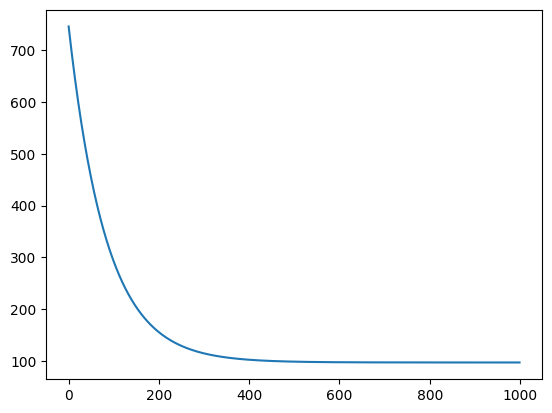

In [133]:
plt.plot(loss)

In [134]:
# Error cuadrático medio

def mse(y_true, y_pred):
    return np.square(y_true - y_pred).mean(axis=0)

mse(y_test, nn.predict(X_test))

array([154.30122841])